In [1]:
from gurobipy import *
import pypsa
import pandas as pd
from dataclasses import dataclass

In [2]:
climatic_year = 2000
time_horizon_in_hours = 365 * 24
network = pypsa.Network()

In [3]:
def add_scandinavia(network: pypsa.Network(), climatic_year: int, time_horizon_in_hours: int):
    full_demand = pd.read_csv("./data/demand_2030_Iberian.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
    full_wind_on_shore = pd.read_csv("./data/capa_factor_2030_Iberian_onshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
    full_solar = pd.read_csv("./data/capa_factor_2030_Iberian_solar.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
    full_wind_off_shore = pd.read_csv("./data/capa_factor_2030_Iberian_offshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))

    

    demand = full_demand.get_group(climatic_year)
    solar = full_solar.get_group(climatic_year)
    wind_on_shore = full_wind_on_shore.get_group(climatic_year)
    wind_off_shore = full_wind_off_shore.get_group(climatic_year)
    
    network.snapshots = demand.index[0:time_horizon_in_hours]
    
    network.add("Bus", name="Iberian_Peninsula", x=-3.7037902, y=40.4168)
    
    coal_marginal_costs = 160
    gas_marginal_costs = 120
    oil_marginal_costs = 100
    nuclear_marginal_costs = 10
    hydro_marginal_costs = 5
    wind_marginal_costs = 5
    solar_marginal_costs = 5
    biomass_marginal_costs = 5


    reservoir_max_hours = 1058
    pumped_max_hours = 590
    battery_max_hours = 2
    H2_max_hours = 0
    
    generators = [
    {"name": "Fossils", "carrier": "Fossils", "p_nom": 2139, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.4,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "BioEnergies", "carrier": "BioEnergies", "p_nom":0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": biomass_marginal_costs, "efficiency": 0.5, 
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Hydroelectric", "carrier":"Hydro", "p_nom": 4196, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": hydro_marginal_costs, "efficiency": 1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_on_shore", "carrier": "Wind_on_shore", "p_nom": 57017, "p_min_pu":wind_on_shore.value, "p_max_pu": wind_on_shore.value, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_off_shore", "carrier": "Wind_off_shore", "p_nom": 3046, "p_min_pu":wind_off_shore.value, "p_max_pu": wind_off_shore.value, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Nuclear", "carrier": "Nuclear", "p_nom": 5100, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": nuclear_marginal_costs, "efficiency":1, "committable": True,
     "min_up_time": 24, "min_down_time": 24},
    {"name": "Solar", "carrier": "Solar", "p_nom": 80606, "p_min_pu":solar.value, "p_max_pu": solar.value, "marginal_cost": solar_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Failure", "carrier": "Failure", "p_nom": 100000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": 100000, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1}
]
    
    storage_units = [
        {"name": "Reservoir", "carrier": "Reservoir", "p_nom": 15180, "p_min_pu": 0, "p_max_pu": 1, "max_hours": reservoir_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Pumped", "carrier": "Pumped", "p_nom": 13367, "p_min_pu": 0, "p_max_pu": 1, "max_hours": pumped_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Battery", "carrier": "Battery", "p_nom": 5000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": battery_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "H2", "carrier": "H2", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1, "max_hours": H2_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" :100, "p_nom_charge" : 100},
]
    
    for generator in generators:
        network.add("Generator", bus="Iberian_Peninsula", **generator,)
    

    for storage in storage_units:
        network.add("Store", bus="Iberian_Peninsula", **storage,)


    loads = [
    {"name": "Iberian_Peninsula-load", "bus": "Iberian_Peninsula", "carrier": "AC","p_set": demand[0:time_horizon_in_hours]["value"].values*1},
    {"name": "Curtailment-load", "bus": "Curtailment", "carrier": "AC","p_set": 10000},
]
    
    for load in loads:
        network.add("Load", **load)

In [6]:
add_Iberian_Peninsula(network, climatic_year, time_horizon_in_hours)

NameError: name 'add_Iberian_Peninsula' is not defined

In [7]:
network

Empty PyPSA Network
Components: none
Snapshots: 1

In [8]:
result = network.optimize(solver_name="gurobi")
print(result)   

IndexError: list index out of range

IndexError: index 0 is out of bounds for axis 0 with size 0

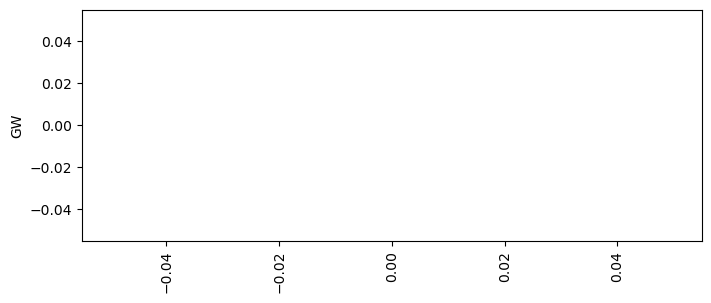

In [9]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

In [ ]:
network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=True, ylabel="GW")